In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import logsumexp as lse
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Step 1: Loading the Digits

In [2]:
import torch
import torchvision
dataset = torchvision.datasets.MNIST(root='./.tmp', train=True, download=True,
                                     transform=torchvision.transforms.Compose([
                                         torchvision.transforms.Resize((16, 16)),
                                         torchvision.transforms.PILToTensor()
                                     ]))
loader = torch.utils.data.DataLoader(dataset, batch_size=100)

i, X, y = 0, [], []

for _x, _y in loader:
    i += 1
    X.append(_x.squeeze())
    y.append(_y)
    if i == 50:
        break
X = torch.cat(X, dim=0).numpy()
y = torch.cat(y, dim=0).numpy()

X = X.astype(np.float64) / 255

In [3]:
X.shape

_, h, w = X.shape
d = h * w

# Step 2: Visualizing the data

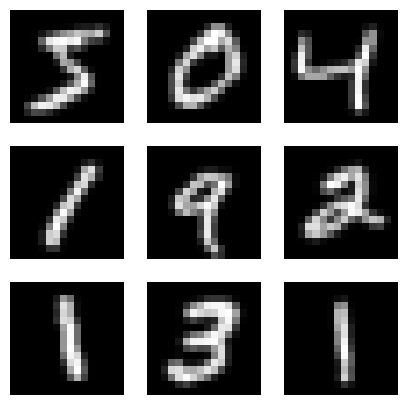

In [4]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))

for ax, xi in zip(axes.flatten(), X):
    ax.imshow(xi, cmap='gray')
    ax.axis('off')

# Introduction: Gaussian MLE

In [5]:
d = h * w
X = X.reshape(-1, h * w)

In [6]:
xmean = np.mean(X, axis=0)
cov = np.cov(X.T)

(-0.5, 15.5, 15.5, -0.5)

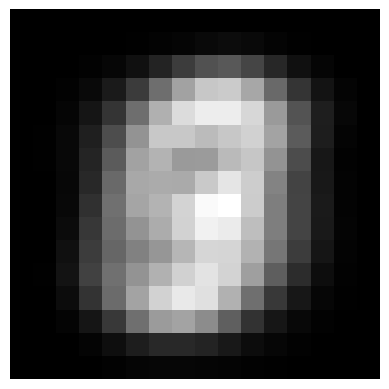

In [7]:
plt.imshow(xmean.reshape(h, w), cmap='gray')
plt.axis('off')

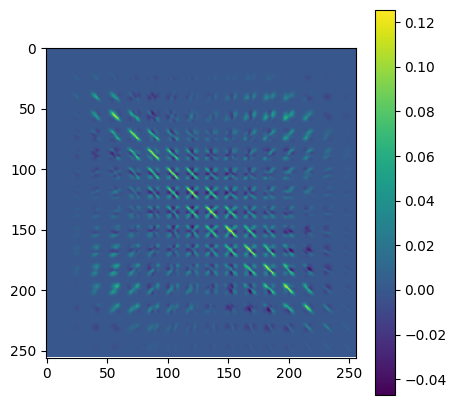

In [8]:
fig = plt.figure(figsize=(5, 5))
im = plt.imshow(cov)
fig.colorbar(im)

In [9]:
new_samples = np.random.multivariate_normal(xmean, cov, size=9)

In [10]:
new_samples.shape

(9, 256)

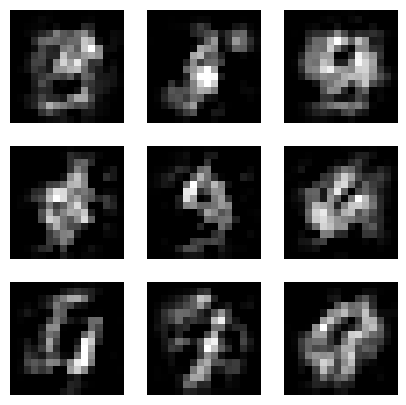

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))

for ax, xi in zip(axes.flatten(), new_samples):
    ax.imshow(np.clip(xi.reshape(h, w), 0, 1), cmap='gray')
    ax.axis('off')

# A Naïve GMM

In [12]:
means = []
covs = []
corrs = []
priors = []

for yu in np.unique(y):
    ind = np.where(y == yu)[0]
    means.append(X[ind, :].mean(axis=0))
    covs.append(np.cov(X[ind, :].T))
    priors.append(len(ind) / len(y))

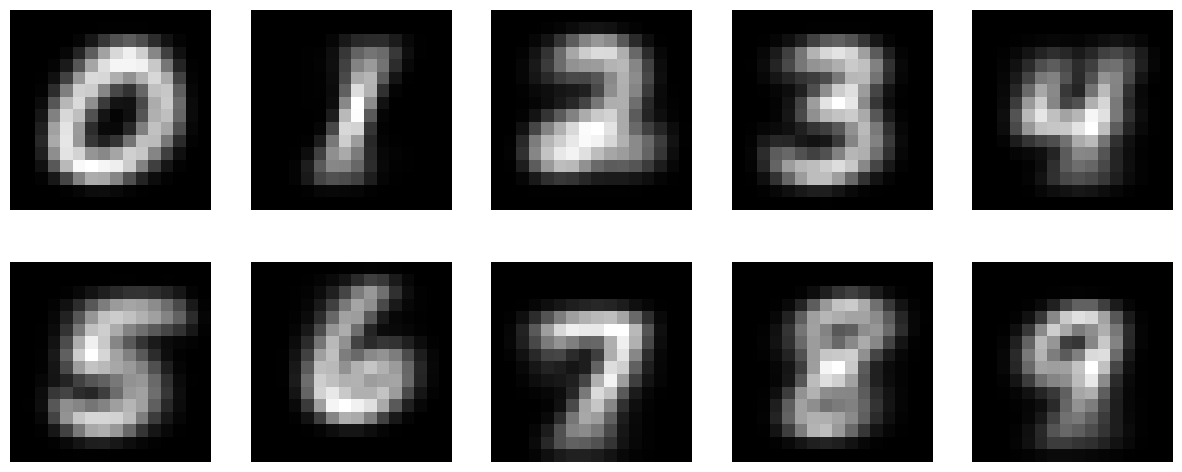

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, m in zip(axes.flatten(), means):
    ax.imshow(m.reshape(h, w), cmap='gray')
    ax.axis('off')

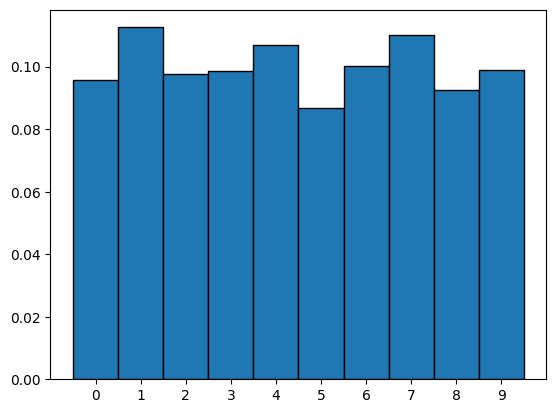

In [14]:
plt.bar(np.arange(len(priors)), priors, width=1, edgecolor='k')
_ = plt.xticks(np.arange(len(priors)))

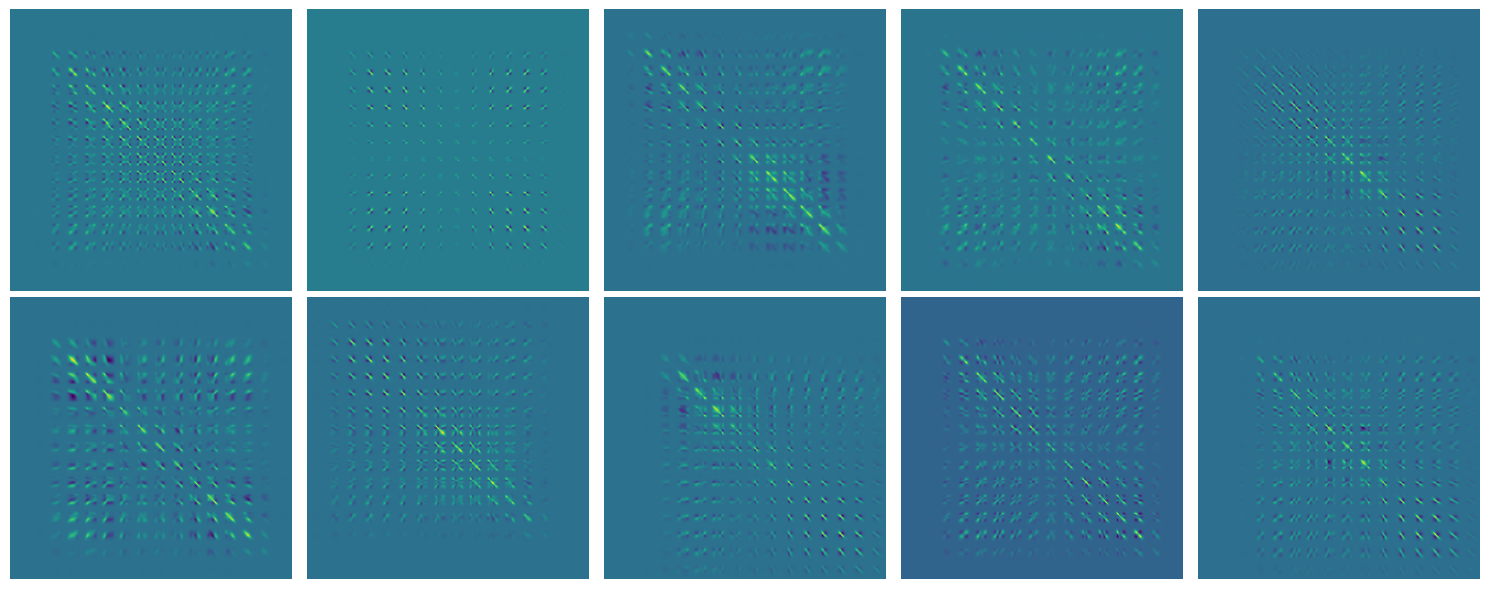

In [15]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, C in zip(axes.flatten(), covs):
    ax.imshow(C)
    ax.axis('off')
plt.tight_layout()

In [16]:
def sample_gmm(means, covs, priors, n=1):
    components = np.arange(len(means))
    selected_components = np.random.choice(components, size=n, p=priors)
    
    new_samples = []
    for ki in selected_components:
        new_samples.append(np.random.multivariate_normal(means[ki], covs[ki], size=1))
    new_samples = np.concatenate(new_samples, axis=0)

    return new_samples

In [17]:
new_samples = sample_gmm(means, covs, priors, n=9)

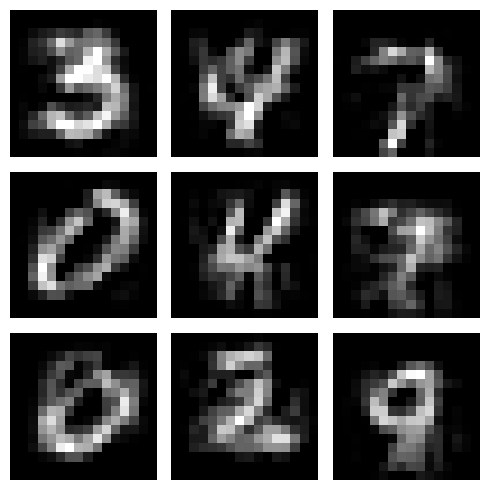

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))

for ax, xi in zip(axes.flatten(), new_samples):
    ax.imshow(np.clip(xi.reshape(h, w), 0, 1), cmap='gray')
    ax.axis('off')
plt.tight_layout()

# K-Means

In [20]:
K = 10

In [21]:
_X = X.copy()
centroids = _X[np.random.choice(np.arange(len(_X)), size=K), :]
centroid_covs = np.zeros([K, d, d])
centroid_w = np.zeros([K,])

kmeans_iter = 0
while True:
    centroids_pre = centroids.copy()
    dists = np.sqrt(np.clip(
        np.linalg.norm(_X, axis=1)[:, None] ** 2 +
        np.linalg.norm(centroids, axis=1)[None, :] ** 2 -
        2 * np.dot(_X, centroids.T), 0.0, None
    ))
    choice_cluster = dists.argmin(axis=1)

    for k in range(K):
        selected = np.where(choice_cluster == k)[0]
        selected = X[selected, ...]
        centroids[k] = selected.mean(axis=0)
        centroid_covs[k] = np.cov(selected.T)
        centroid_w[k] = len(selected) / len(_X)
    centroids_delta = np.linalg.norm(centroids - centroids_pre)

    kmeans_iter += 1

    if centroids_delta < 1e-5:
        break

    if kmeans_iter % 100 == 0:
        print(kmeans_iter, centroids_delta)

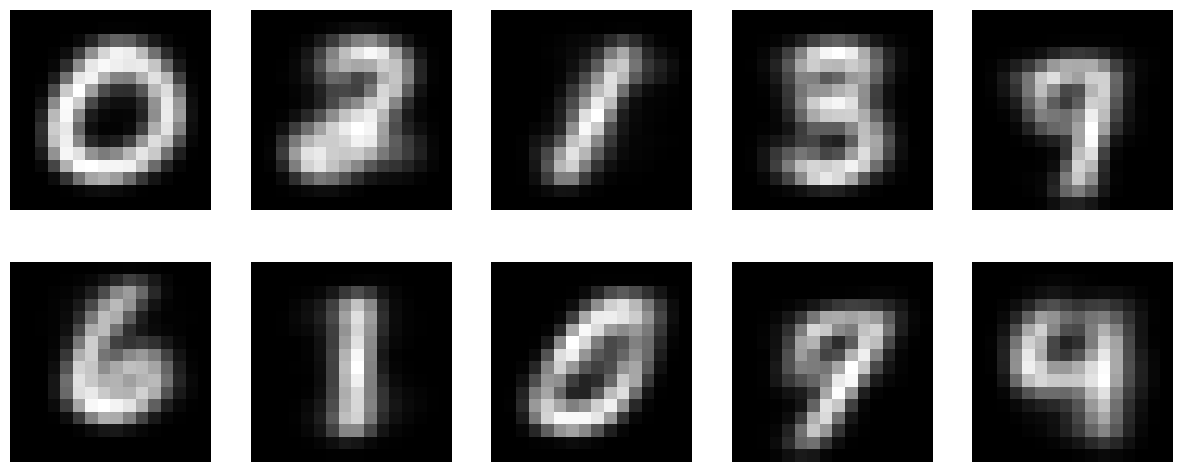

In [22]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, m in zip(axes.flatten(), centroids):
    ax.imshow(m.reshape(h, w), cmap='gray')
    ax.axis('off')

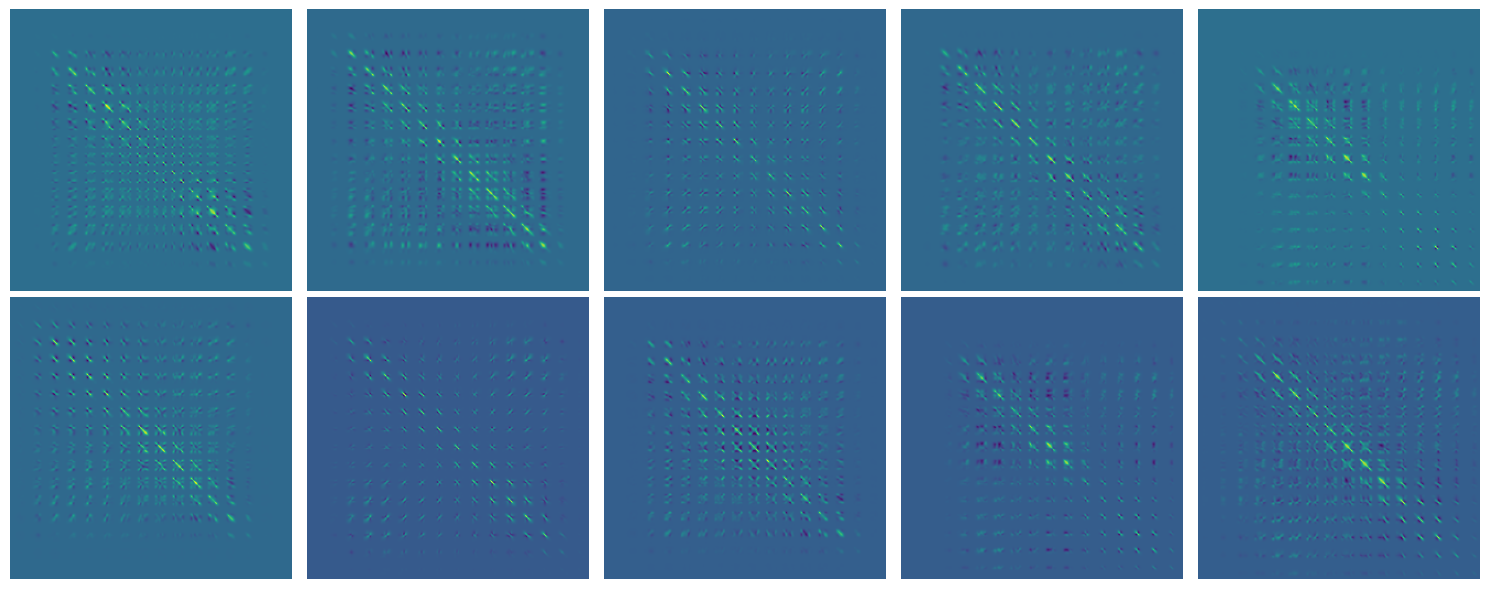

In [23]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, C in zip(axes.flatten(), centroid_covs):
    ax.imshow(C)
    ax.axis('off')
plt.tight_layout()

# Expectation Maximization

In [24]:
def log_gauss_pdf(x, m, D, U, reg=1e-6):
    d = x.shape[1]
    # r = x - m
    # r = np.dot(X - m, np.dot(np.diag(D ** (1 / 2)), U.T))
    r = x - m
    D = np.clip(D.real, reg, None)
    U = U.real
    log_det = np.sum(np.log(D))
    inv_cov = np.dot(U, np.dot(np.diag(1 / D), U.T))
    return -0.5 * (d * math.log(2 * math.pi) +
                   log_det +
                   np.diag(np.dot(r, np.dot(inv_cov, r.T))))

In [25]:
K = 10

In [27]:
pi = centroid_w.copy()
means = centroids.copy()
covs = centroid_covs.copy()

In [ ]:
pi = np.ones(K) / K
pi = pi / pi.sum()

means = X.mean(axis=0) + 0.5 * np.random.randn(K, d)

covs = np.zeros((K, d, d))
for k in range(K):
    A = np.random.randn(d, d)
    covs[k] += 0.1 * np.eye(d) + .01 * np.dot(A, A.T)

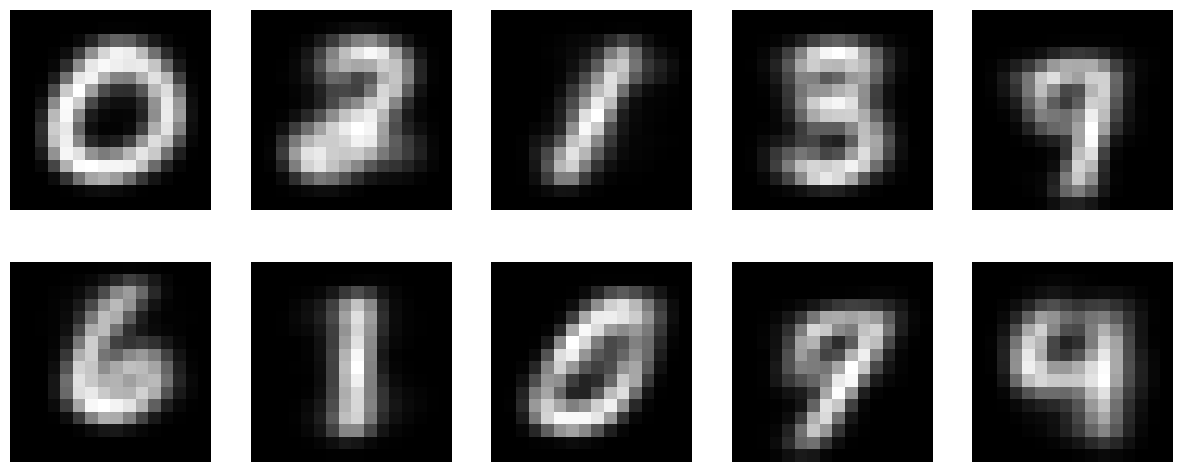

In [28]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, m in zip(axes.flatten(), means):
    ax.imshow(m.reshape(h, w), cmap='gray')
    ax.axis('off')

In [29]:
X.shape

(5000, 256)

In [30]:
L = lse(
    np.stack([math.log(pi[k]) +
              log_gauss_pdf(X, means[k], *np.linalg.eig(covs[k])) for k in range(K)]), axis=0).mean()

print(L)

hist = {
    'likelihood': [L],
    'means': [means.copy(),],
    'covs': [covs.copy(),],
    'weights': [pi.copy(),]
}

769.4602235862815


In [31]:
for it in range(100):
    # Expectation Step
    g = np.zeros([len(X), K])
    for k in range(K):
        g[:, k] = np.exp(math.log(pi[k]) +
                         log_gauss_pdf(X, means[k, :], *np.linalg.eig(covs[k, ...]), reg=1e-3))
    G = g / g.sum(axis=1)[:, None]

    # Maximization Step
    for k in range(K):
        means[k] = np.dot(G[:, k], X) / G.sum(axis=0)[k]
        covs[k] = np.einsum('i,ij,ik->jk', G[:, k], X - means[k], X - means[k]) / G.sum(axis=0)[k]
        pi[k] = G[:, k].sum() / len(X)

    # Evaluates the Likelihood Function
    L = lse(
        np.stack([math.log(pi[k]) +
                  log_gauss_pdf(X, means[k], *np.linalg.eig(covs[k])) for k in range(K)]), axis=0).mean()

    print(it, L)

    # Add to history
    hist['likelihood'].append(L.copy())
    hist['means'].append(means.copy())
    hist['covs'].append(covs.copy())
    hist['weights'].append(pi.copy())

0 789.930831413057
1 796.0263753252752
2 798.2320182858882
3 800.0381177692425
4 801.2210052081149
5 801.8306861842555
6 802.3068847307413
7 802.6652425425607
8 803.2493983884418
9 803.4039074862192
10 803.4832630036568
11 803.5947144892173
12 803.6670319442144
13 803.7785062063471
14 803.8794932093236
15 804.228466144217
16 804.7420482655871
17 805.1291025393913
18 805.2041110921535
19 805.3023463967762
20 805.3560949707871
21 805.5222619409649
22 805.8852049635386
23 805.8885557249554
24 805.9010174521275
25 805.9058315527756
26 805.9303857795815
27 805.9261438815869
28 805.9904099992735
29 806.0039880663072
30 806.047420246712
31 806.0490103345454
32 806.074356762668
33 806.1100183384862
34 806.1025758039086
35 806.1398787852762
36 806.1456187664996
37 806.155147185466
38 806.153083036643
39 806.1306599041754
40 806.1608097707192
41 806.1325803283773
42 806.1365303356996
43 806.155268702679
44 806.1666817789653
45 806.135231517926
46 806.147425221399
47 806.1619108061439
48 806.1504

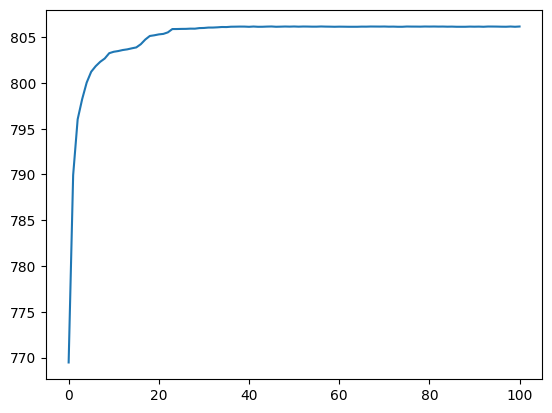

In [32]:
plt.plot(hist['likelihood'])

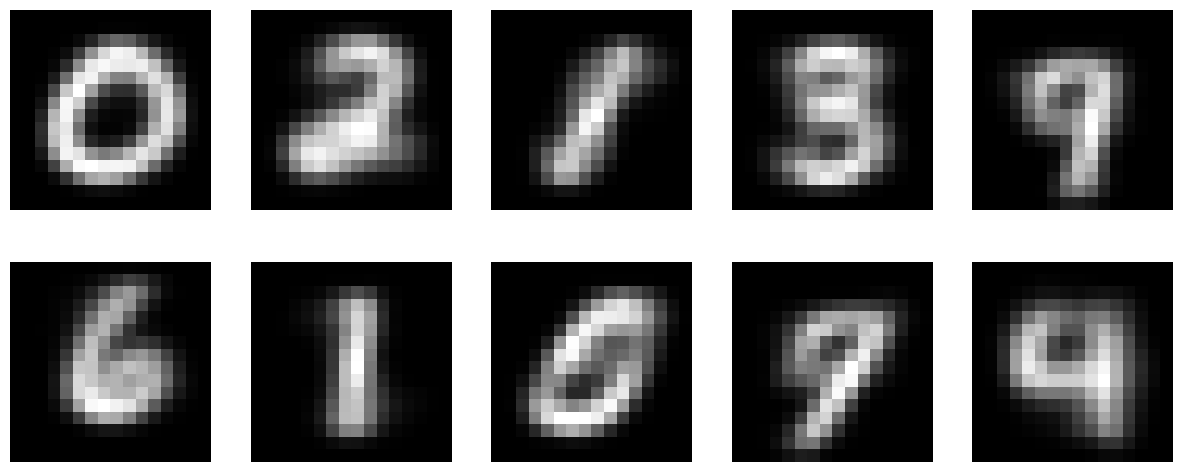

In [33]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, m in zip(axes.flatten(), means):
    ax.imshow(m.reshape(h, w), cmap='gray')
    ax.axis('off')

In [34]:
new_samples = sample_gmm(means, covs, pi, n=9)

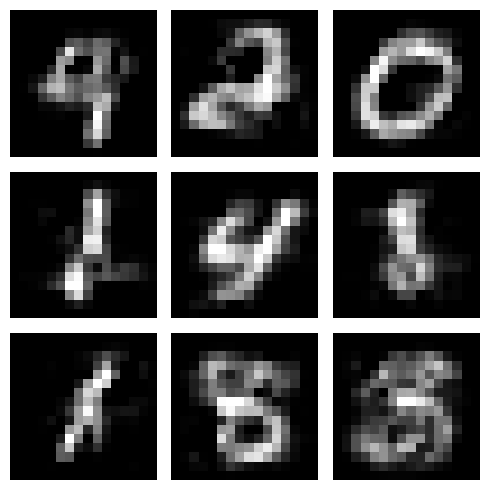

In [35]:
fig, axes = plt.subplots(3, 3, figsize=(5, 5))

for ax, xi in zip(axes.flatten(), new_samples):
    ax.imshow(np.clip(xi.reshape(h, w), 0, 1), cmap='gray')
    ax.axis('off')
plt.tight_layout()

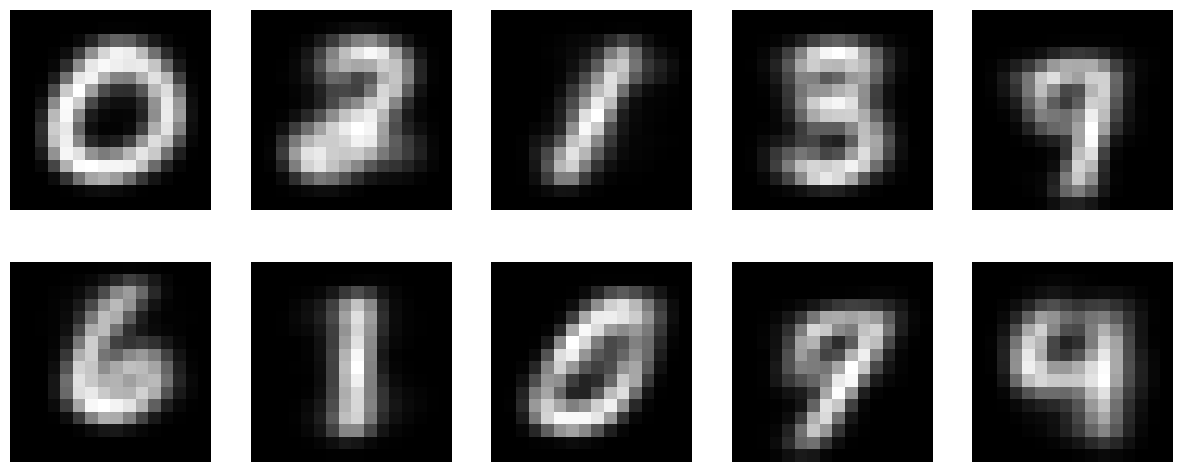

In [36]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, m in zip(axes.flatten(), hist['means'][0]):
    ax.imshow(m.reshape(h, w), cmap='gray')
    ax.axis('off')

def update(frame):
    # clear the axis each frame
    for ax in axes.flatten():
        ax.clear()

    for ax, m in zip(axes.flatten(), frame):
        ax.imshow(m.reshape(h, w), cmap='gray')
        ax.axis('off')

anim = FuncAnimation(fig, update, frames=hist['means'])

In [37]:
HTML(anim.to_jshtml())